# Profile of `maze_dataset` Dumping and Loading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		# np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		np.logspace(0, 4, 9, dtype=int).tolist(), # 10k
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    d.cfg.serialize_minimal_threshold = None
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize', _d_cpy.serialize, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
        'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_min_cat, result_serialize_min_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load', lambda: MazeDataset.load(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_min_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    d.cfg.serialize_minimal_threshold = None
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    d.cfg.serialize_minimal_threshold = 0
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    d.cfg.serialize_minimal_threshold = None

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/9:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001EF5202CFE0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
	{'grid_n': 10, 'n_mazes': 1, 'serialize': 0.0020392999285832047, 'serialize_minimal': 0.0037748999893665314, 'serialize_minimal_alt': 0.0028773999074473977, 'serialize_minimal_soln_cat': 0.002738500013947487, 'load': 0.007883999962359667, 'load_minimal': 0.0029770999681204557, 'load_minimal_soln_cat': 0.0029360000044107437, 'save': 0.018467099987901747, 'read': 0.011059099924750626, 'save_minimal': 0.019099900033324957, 'read_minimal': 0.013058899901807308}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001EF5202CFE0>, maze_ctor_kwargs={}, serializ

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS


,grid_n,n_mazes,serialize,serialize:stats,serialize:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_alt,serialize_minimal_alt:stats,...,save:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,1,0.002039,{0.0020392999285832047: 1},<pstats.Stats object at 0x000001EF52194310>,0.003775,{0.0037748999893665314: 1},<pstats.Stats object at 0x000001EF531D8F50>,0.002877,{0.0028773999074473977: 1},...,<pstats.Stats object at 0x000001EF5211D6D0>,0.011059,{0.011059099924750626: 1},<pstats.Stats object at 0x000001EF532A0790>,0.019100,{0.019099900033324957: 1},<pstats.Stats object at 0x000001EF52102C10>,0.013059,{0.013058899901807308: 1},<pstats.Stats object at 0x000001EF53275BD0>
1,10,3,0.001809,{0.0018091000383719802: 1},<pstats.Stats object at 0x000001EF5321CB90>,0.002621,{0.0026207000482827425: 1},<pstats.Stats object at 0x000001EF3199DE50>,0.003176,{0.003176300087943673: 1},...,<pstats.Stats object at 0x000001EF5211D690>,0.015738,{0.01573790004476905: 1},<pstats.Stats object at 0x000001EF534CEED0>,0.019277,{0.01927689998410642: 1},<pstats.Stats object at 0x000001EF50A97E50>,0.010131,{0.010130799957551062: 1},<pstats.Stats object at 0x000001EF51FE6A90>
2,10,10,0.003195,{0.003194799995981157: 1},<pstats.Stats object at 0x000001EF534DF390>,0.004083,{0.0040834000101312995: 1},<pstats.Stats object at 0x000001EF55163190>,0.003351,{0.0033508000196889043: 1},...,<pstats.Stats object at 0x000001EF65551A90>,0.031483,{0.03148260002490133: 1},<pstats.Stats object at 0x000001EF53548890>,0.018319,{0.018319099908694625: 1},<pstats.Stats object at 0x000001EF53277CD0>,0.010184,{0.010183800011873245: 1},<pstats.Stats object at 0x000001EF535F9950>
3,10,31,0.001910,{0.0019097999902442098: 1},<pstats.Stats object at 0x000001EF53654D50>,0.006775,{0.006774500012397766: 1},<pstats.Stats object at 0x000001EF3199E790>,0.006064,{0.006063899956643581: 1},...,<pstats.Stats object at 0x000001EF50B4CED0>,0.075932,{0.07593209994956851: 1},<pstats.Stats object at 0x000001EF53783D50>,0.020711,{0.020710699958726764: 1},<pstats.Stats object at 0x000001EF50BF5690>,0.010979,{0.010978900012560189: 1},<pstats.Stats object at 0x000001EF531A9FD0>
4,10,100,0.002952,{0.0029519000090658665: 1},<pstats.Stats object at 0x000001EF52197F50>,0.017910,{0.01790970005095005: 1},<pstats.Stats object at 0x000001EF53C7E550>,0.014864,{0.014863900025375187: 1},...,<pstats.Stats object at 0x000001EF538A8F50>,0.232220,{0.23221970000304282: 1},<pstats.Stats object at 0x000001EF53F6AED0>,0.026480,{0.026479699998162687: 1},<pstats.Stats object at 0x000001EF53CA8650>,0.011341,{0.011340799974277616: 1},<pstats.Stats object at 0x000001EF53C70690>
5,10,316,0.003630,{0.0036300000501796603: 1},<pstats.Stats object at 0x000001EF54048910>,0.061440,{0.06144049996510148: 1},<pstats.Stats object at 0x000001EF596B7DD0>,0.056291,{0.056291399989277124: 1},...,<pstats.Stats object at 0x000001EF53367450>,0.756402,{0.7564016000833362: 1},<pstats.Stats object at 0x000001EF51CB4750>,0.071281,{0.0712807000381872: 1},<pstats.Stats object at 0x000001EF53D42190>,0.016448,{0.016448399983346462: 1},<pstats.Stats object at 0x000001EF53D32950>
6,10,1000,0.009246,{0.009246299974620342: 1},<pstats.Stats object at 0x000001EF493D8D10>,0.206062,{0.2060619000112638: 1},<pstats.Stats object at 0x000001EF559C8A90>,0.151914,{0.1519137000432238: 1},...,<pstats.Stats object at 0x000001EF548F1B90>,2.345860,{2.3458600000012666: 1},<pstats.Stats object at 0x000001EF520D5910>,0.109378,{0.10937780002132058: 1},<pstats.Stats object at 0x000001EF54897390>,0.022663,{0.022663400042802095: 1},<pstats.Stats object at 0x000001EF55487C50>
7,10,3162,0.022264,{0.022264299914240837: 1},<pstats.Stats object at 0x000001EF54087050>,0.504668,{0.504668099922128: 1},<pstats.Stats object at 0x000001EF5A317850>,0.424522,{0.4245221000164747: 1},...,<pstats.Stats object at 0x000001EF56C86390>,7.127809,{7.1278

In [7]:


def compute_speedups(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> pd.DataFrame:
    for prefix in column_measurement_prefixes:
        speeds[f'{prefix}_speedup'] = speeds[f'{prefix}'] / speeds[f'{prefix}_minimal']
    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [8]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize,serialize_minimal,serialize_minimal_alt,serialize_minimal_soln_cat,load,load_minimal,load_minimal_soln_cat,save,read,save_minimal,read_minimal,serialize_speedup,load_speedup,save_speedup,read_speedup
0,10,1,0.002039,0.003775,0.002877,0.002739,0.007884,0.002977,0.002936,0.018467,0.011059,0.019100,0.013059,0.540226,2.648215,0.966869,0.846863
1,10,3,0.001809,0.002621,0.003176,0.002392,0.010344,0.003264,0.004186,0.026911,0.015738,0.019277,0.010131,0.690312,3.168929,1.396044,1.553471
2,10,10,0.003195,0.004083,0.003351,0.003230,0.025504,0.003361,0.003179,0.041363,0.031483,0.018319,0.010184,0.782387,7.588295,2.257900,3.091439
3,10,31,0.001910,0.006775,0.006064,0.005690,0.067616,0.003271,0.003346,0.095358,0.075932,0.020711,0.010979,0.281910,20.672710,4.604287,6.916185
4,10,100,0.002952,0.017910,0.014864,0.015095,0.268419,0.004937,0.004366,0.250111,0.232220,0.026480,0.011341,0.164821,54.368767,9.445375,20.476483
5,10,316,0.003630,0.061440,0.056291,0.043012,0.712774,0.006288,0.006948,0.262991,0.756402,0.071281,0.016448,0.059082,113.352809,3.689509,45.986333
6,10,1000,0.009246,0.206062,0.151914,0.140410,2.296268,0.011404,0.019327,1.339636,2.345860,0.109378,0.022663,0.044871,201.361681,12.247785,103.508741
7,10,3162,0.022264,0.504668,0.424522,0.438501,6.918109,0.042060,0.042665,2.515509,7.127809,0.254443,0.037815,0.044117,164.482701,9.886330,188.490082
8,10,10000,0.055038,1.627554,1.316900,1.312601,21.432936,0.070243,0.124152,8.863860,24.401328,0.850664,0.101370,0.033816,305.123848,10.419932,240.714288


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


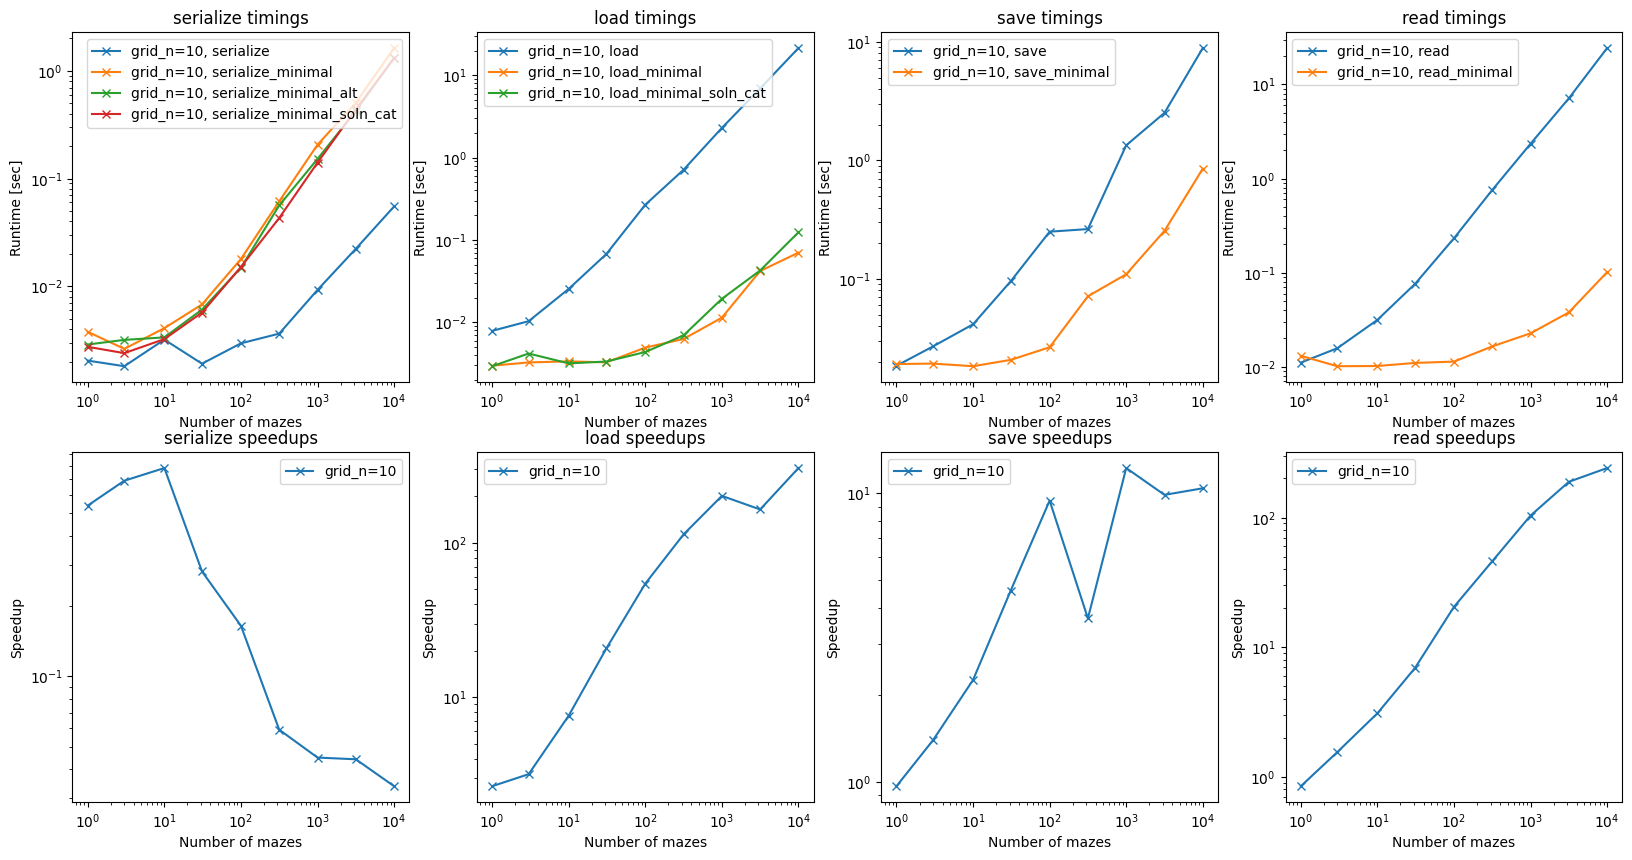

In [9]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            # ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}'], "x-", label=f'grid_n={grid_n}, {prefix}')
            # ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}_minimal'], "x-", label=f'grid_n={grid_n}, {prefix}_minimal')

            # _alt = f'{prefix}_minimal_alt'
            # if _alt in speeds.columns:
            #     ax_timings.plot(x_n_mazes, speeds_masked[_alt], "x-", label=f'grid_n={grid_n}, {_alt}')
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}_speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [10]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_soln_cat:profiling']]

,grid_n,n_mazes,serialize_minimal_soln_cat:profiling
0,10,1,<pstats.Stats object at 0x000001EF53209A90>
1,10,3,<pstats.Stats object at 0x000001EF53320210>
2,10,10,<pstats.Stats object at 0x000001EF4EA618D0>
3,10,31,<pstats.Stats object at 0x000001EF5214C7D0>
4,10,100,<pstats.Stats object at 0x000001EF53701D10>
5,10,316,<pstats.Stats object at 0x000001EF599910D0>
6,10,1000,<pstats.Stats object at 0x000001EF53641A90>
7,10,3162,<pstats.Stats object at 0x000001EF5A2CA890>
8,10,10000,<pstats.Stats object at 0x000001EF6208F990>


In [12]:
SPEEDS['serialize_minimal_soln_cat:profiling'][8].sort_stats('cumulative').print_stats(20)

         16055 function calls (15830 primitive calls) in 0.045 seconds

   Ordered by: cumulative time
   List reduced from 88 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.028    0.028    0.045    0.045 maze_dataset.py:434(_serialize_minimal_soln_cat)
    10001    0.010    0.000    0.010    0.000 {built-in method numpy.array}
        2    0.000    0.000    0.005    0.002 json_serialize.py:271(json_serialize)
    195/2    0.000    0.000    0.005    0.002 json_serialize.py:231(json_serialize)
        1    0.000    0.000    0.004    0.004 json_serialize.py:124(_serialize_override_serialize_func)
        1    0.000    0.000    0.004    0.004 serializable_dataclass.py:356(serialize)
        1    0.000    0.000    0.004    0.004 maze_dataset.py:62(<lambda>)
        1    0.000    0.000    0.004    0.004 util.py:122(safe_getsource)
        1    0.000    0.000    0.004    0.004 inspect.py:1256(getsource)
        1    0.000